In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline

from helper.rl_framework import *
from helper.rl_functions import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *


# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:19.dict'
filename = '3000orderbooks'
currency_pair = 'USDT_BTC'
offset = 0
orderbooks = load_orderbook_snapshot(infile=filename)  #, first_line=offset+0, last_line=offset+10)
print("Successfully loaded {} orderbooks from '{}'".format(len(orderbooks), filename))
print(orderbooks[0])

100%|██████████| 3000/3000 [02:18<00:00, 21.64it/s]

Loaded 3000 orderbooks from file '3000orderbooks'.
Successfully loaded 3000 orderbooks from '3000orderbooks'
OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'


### Settings

In [222]:
V = 100  # trading volume
T = 4  # Time horizon: 10 periods -> P*T = 20 minutes
P = 2  # period length
print("V={}, T={}, P={}".format(V, T, P))

V=100, T=4, P=2


#### Split orderbook array into non-overlapping episodes

Episodes: 187, episode length: 16


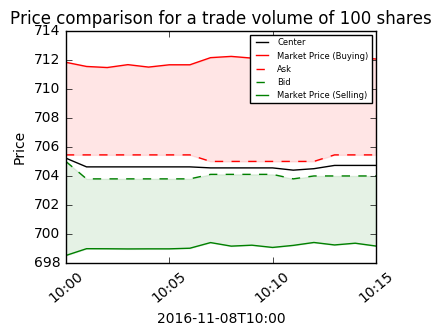

In [213]:
def create_episodes(orderbooks, episode_length):
    episode_windows = []
    for e in range(0, len(orderbooks) / episode_length):
        window = [ob.copy() for ob in orderbooks[e*episode_length:(e+1)*episode_length]]

        # plot_episode(window, volume=V, outfile='graphs/episode_window{}'.format(e))
        episode_windows.append(window)
    return episode_windows

episode_windows = create_episodes(orderbooks, episode_length=T*P)

print("Episodes: {}, episode length: {}".format(len(episode_windows), len(episode_windows[0])))
plot_episode(episode_windows[0], volume=V)

In [214]:
from Q_learning import QLearn

In [219]:
STATE_DIM = 2
NUM_ACTIONS = 19
actions = list(np.linspace(-1, 15, num=NUM_ACTIONS))

# actions=[-1., 0, 1., 2., 3., 4., 5.]
NUM_ACTIONS = len(actions)

In [220]:
def round_custombase(val, base):
    return round(val / base) * base

round_custombase(12.43, base=5)

10.0

  0%|          | 0/20 [00:00<?, ?it/s]

V: 200, H: 8, T: 4, I: 5, L: 19
actions: [-1.0, -0.11111111111111116, 0.77777777777777768, 1.6666666666666665, 2.5555555555555554, 3.4444444444444446, 4.333333333333333, 5.2222222222222214, 6.1111111111111107, 7.0, 7.8888888888888893, 8.7777777777777768, 9.6666666666666661, 10.555555555555555, 11.444444444444443, 12.333333333333332, 13.222222222222221, 14.111111111111111, 15.0]
volumes_base: 50
volumes: [ 200.  150.  100.   50.]



100%|██████████| 4/4 [10:44<00:00, 169.96s/it]


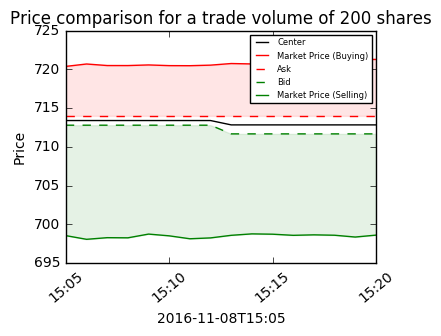

(200, 5)
volumes: [  50.  100.  150.  200.]
V: 200, T: 4


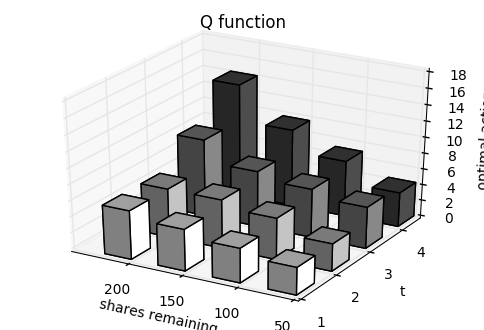


[4, 50]
[ 0.32394909  0.32394909  0.322404    0.31813849  0.3123575   0.30757793
  0.30651455  0.30651455  0.30785232  0.31226509  0.31437079  0.31574551
  0.31826019  0.31826019  0.31826019  0.31826019  0.31826019  0.31826019
  0.31826019]

[4, 200]
[ 3.22639799  3.22639799  3.22046478  3.20096311  3.17614213  3.1558884
  3.1464998   3.1464998   3.14552395  3.11830426  3.11830426  3.11830214
  3.1050108   3.10422762  3.10422762  3.10198212  3.09836235  3.09758083
  3.09758083]

[4, 150]
[ 1.77400014  1.77400014  1.76979346  1.75703086  1.74293596  1.73147644
  1.72670246  1.72670246  1.7262459   1.712586    1.712586    1.71258515
  1.71206411  1.71237856  1.71485503  1.71603164  1.71827149  1.73554387
  1.74292711]

[4, 100]
[ 0.89844494  0.89844494  0.8960732   0.88900518  0.880446    0.87391201
  0.87162882  0.87162882  0.871378    0.86687436  0.86687436  0.87177569
  0.87963352  0.89353699  0.89571072  0.89571072  0.89571072  0.89571072
  0.89571072]

[3, 50]
[ 0.29118883  0.30651

In [223]:
def optimal_strategy(V, H, T, I, L, actions):
    print("V: {}, H: {}, T: {}, I: {}, L: {}".format(V, H, T, I, L))
    print("actions: {}".format(actions))
    volumes = np.linspace(0, V, num=I+1)[1:][::-1] # skip volumes=0
    volumes_base = V/I
    print("volumes_base: {}".format(volumes_base))
    print("volumes: {}".format(volumes))
    ql = QLearn(actions=actions)

    decisionfrequency = H/T
    for tt in tqdm(range(T, 0, -1)):

        for episode in tqdm(episode_windows[:20]):
            obs_ = episode[decisionfrequency * (tt-1):decisionfrequency * tt]
            obs = [elem.copy() for elem in obs_]

            center = obs[0].get_center()
            ask = obs[0].get_ask()
            initial_center = episode[0].get_center()
            # print("center: {}".format(center))
            
            for vol in volumes:
                for a in actions:
                    state = '[{}, {:2d}]'.format(tt,int(vol))
                    # print("")
                    # print(tt, vol, a, state)
                    if vol == 0:
                        volume_left = 0
                        cost = 0
                    else:
                        ots = OrderbookTradingSimulator(volume=vol, tradingperiods=T-tt+1,
                                                        decisionfrequency=decisionfrequency)
                    
                        limit = center + a
                        # print(state, actions[a], limit)
                        ots.trade(obs, limit = limit)  # agression_factor=a)
                    
                        volume_left = ots.volume
                        volume_left_rounded = round_custombase(volume_left, base=volumes_base)
            
                        volume_traded = ots.history.volume_traded.values[-1]
                        volume_traded_rounded = round_custombase(volume_traded, base=volumes_base)
                        
                        assert volume_left_rounded + volume_traded_rounded == vol
                        
                        cashflow = ots.history.cashflow[-1]
                        
                        avg = ots.history.avg[-1]
                        cost = volume_traded_rounded * (avg - initial_center) / initial_center
            
                    new_state = '[{}, {:2d}]'.format(tt+1, int(volume_left_rounded))
                    
                    ql.learn(state, a, cost, new_state)
                    # print("  {:1.4f} {:1.4f} {:1.0f} {:1.0f} ".format(cost, (initial_center - avg) / initial_center, volume_traded, volume_traded_rounded))
        ql.plot_Q2(V, T)
    plot_episode(episode, volume=V)
    return ql

V = 200
ql = optimal_strategy(V=V, H=T*P, T=T, I=4, L=NUM_ACTIONS, actions=actions)
ql.plot_Q2(V, T)

for key in sorted(ql.q)[::-1]:
    print("")
    print(key)
    print(ql.q[key])

[ nan  nan  nan  nan  nan]
(100, 5)
volumes: [  25.   50.   75.  100.]
V: 100, T: 4


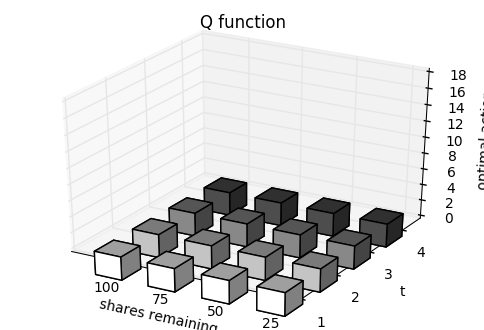

In [209]:
test = ql.q['[4, 100]']
print(test)

# ql = QLearn(actions=actions)
ql.plot_Q2(V, T)

In [ ]:
# states:
# [volume_left, time_left]
I = 5
print("V: {}, T: {}, I: {}".format(V, T, I))
volumes_rounded = [I*x for x in range(V/I+1)]
print("volume_left", volumes_rounded)

print(zip(volumes_rounded, range(T)))

states = []
for i in volumes_rounded:
    for j in range(T):
        states.append([i, j])
display(states)

qtable = np.zeros(len(states))
display(qtable, qtable.shape)

qtable[4, ]

display(qtable, qtable.shape)

In [ ]:
def train_RL(V, T, P, epochs, gamma=0.95, DECAY_RATE=0.005, epsilon=1., bufferSize=50, batchSize=30, verbose=False, log=None):
    
    model = base_model()
    if log:
        log = open('logs/RL_train_{}.log'.format(datetime.now().isoformat()[2:-10]), 'w')
        log.write("RL training started\n")
        log.write("Actions: {}\n".format(actions))
        log.write("V={}, T={}, P={}\n".format(V, T, P))
        log.write("Compiled model!")
    MAX_EXPLORATION_RATE = 1.
    MIN_EXPLORATION_RATE = 0.05
    
    min_costs = np.inf

    replay = Memory(bufferSize)
    # stores tuples of (S, A, R, S')

    for i_episode in tqdm(range(epochs)):
        obs = episode_windows[0]  # episode_windows[i]  # Testcase with always the same, identical episode_window

        ots = OrderbookTradingSimulator(volume=V, tradingperiods=T, decisionfrequency=P)

        time_left = T
        volume = V
        action_history = []
        state = np.array([time_left, volume])  # volume])

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            # print("     {}".format(qval))

            ob = obs[step*P]
 
            if random.random() < epsilon:
                # choose random action
                #action = random.randint(0, len(actions)-1)
                # action = round(random.random()*2.-1, 1)
                action = random.choice(actions)
            else:
                # choose best action from Q(s,a) values
                action = actions[np.argmin(qval)]
            action_history.append(action)    
            if verbose:
                print("{}: action {}".format(action, actions[action]))
                
            # if V > 0:
            #     best_price = ob.get_ask()
            # elif V < 0:
            #     best_price = ob.get_bid()
            # else:
            #     assert(1 == 2), "Error!"
            # lim = best_price - actions[action]
            
            orderbooks = obs[step*P:(step+1)*P]
            info = ots.trade(orderbooks, agression_factor=action, verbose=False, extrainfo={'ACTION':action})


            time_left -= 1
            volume = ots.volume

            new_state = np.array([time_left, volume])  # volume, 
            cost = ots.history.cost.values[-1]
            if info['forced'].values[0]:
                pass
                # cost *= 3
            acc_cost += cost

            replay.add((state, action, cost, new_state))
            if (replay.size() >= bufferSize):
                # wait for buffer to be filled, before getting started with training
                minibatch = replay.get_random_samples(batchSize)           

                X_train = []
                y_train = []
                for memory in minibatch:
                    state_m, action_m, cost_m, new_state_m = memory

                    qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                    y = np.zeros((1, NUM_ACTIONS))
                    y[:] = qval_old[:]

                    qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                    maxQ = np.max(qval_new_m)

                    update = cost_m + (gamma*maxQ)
                    y[0][action_m] = update  # target output

                    X_train.append(state_m.reshape(STATE_DIM,))
                    y_train.append(y.reshape(NUM_ACTIONS,))
                X_train = np.array(X_train)
                y_train = np.array(y_train)

                # print("Game #: %s" % (i_episode,))
                model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            state = new_state
            if volume == 0:
                # display(ots.history)
                break

        # reduce exploration rate
        if epsilon > MIN_EXPLORATION_RATE:
            epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
            
        forced_trade = ""
        if info['forced'].values[0]:
            forced_trade = ", forced!"
        info = "{:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, steps: {} (t={}) {}\n"\
                .format(i_episode+1, epochs, epsilon,  acc_cost, step, ots.t, forced_trade)
        if log:
            log.write(info)
        if min_costs > acc_cost:
            min_costs = acc_cost
            if log:
                log.write("   {}\n".format(action_history))
            
            print(info)
            print("   {}".format(action_history))
            display(ots.history)
        # print("     {}".format(action_history))
    log.close()

In [ ]:
V=30
T=5
P=2

train_RL(V=V, T=T, P=P, epochs=300, verbose=False, log=True)

In [ ]:
visualize_Q(model, actions, V, T)

In [ ]:
def run(V, T, P, epochs=1, overwrite_actions=None):
    for i_episode in range(epochs):
        obs = episode_windows[0]  # episode_windows[i]  # Testcase with always the same, identical episode_window

        ots = OrderbookTradingSimulator(volume=V, tradingperiods=T, decisionfrequency=P)

        time_left = P*T
        volume = V

        state = np.array([time_left, volume])  # , volume])
        # state = discretize_state(state)

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            
            action = actions[np.argmin(qval)]
            
            if overwrite_actions and step < len(overwrite_actions):
                action = overwrite_actions[step]

            ob = obs[step*P]

            orderbooks = obs[step*P:(step+1)*P]
            # info = ots.trade(orderbooks, limit=lim, verbose=False)
            info = ots.trade(orderbooks, agression_factor=action, verbose=False, extrainfo={'ACTION':action})

            time_left -= 1
            volume = ots.volume
            new_state = np.array([time_left, volume])  # , volume])
            cost = ots.history.cost.values[-1]

            acc_cost += cost

            state = new_state
            if volume == 0:
                break

        info = "{:4d}/{}: acc_cost: {:0.5f}, steps: {} (t={})"\
                .format(i_episode+1, epochs, acc_cost, step, ots.t)
        print(info)
    return ots.history
hist = run(V=V, T=T, P=P)  #, overwrite_actions=[0,0,0,0,0,0,0,0,0])
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.24]*10)
display(hist)

In [ ]:
plot_episode(episode_windows[3], volume=50, figsize=(5,3))
episode_windows[3][90].plot(range_factor=1.015, figsize=(5,3))

In [ ]:
def show_plots(x):
    # episode_windows[3][x].plot(range_factor=1.015, figsize=(5,3))
    return x

from ipywidgets import interact
interact(show_plots, x=5)

In [ ]:
print(len(obs))
for vol in [1, 50, 100]:
    market_order_price = []
    ask_price = []
    for i, ob in enumerate(obs):
        market_order_price.append(ob.get_current_price(volume=vol))
        ask_price.append(vol*ob.get_ask())

    plt.plot(market_order_price, color='blue', marker='o', label='market order price')
    plt.plot(ask_price, color='red', marker='*', label='ask price')
                         
                         
    
    plt.title("Market order price for {} shares".format(vol))
    plt.ylabel("price")
    plt.xlabel("time")
    plt.legend(loc='best')
    plt.xlim((-1,21))
    plt.show()